In [1]:
import sqlite3
import pandas as pd

# ----- SCHRITT 1: Datenbankabfrage -----
db_path = 'sqlite-dll-win-x64-3490100/produktionsmanagement.db'
conn = sqlite3.connect(db_path)

# Lade Lagerbestand aus der Tabelle "teilelager"
teilelager_df = pd.read_sql("SELECT * FROM teilelager", conn)
# Umwandlung des Lagerbestands in ein Dictionary: Schlüssel = Artikel-Nr., Wert = verfügbare Menge
inventory = teilelager_df.set_index('Artikel-Nr.')['Menge'].to_dict()

# Lade Produktionsplan aus der Tabelle "production_plan"
# Die Tabelle "production_plan" enthält die Spalten: Model, Nr, Kunde, Termin
production_plan_df = pd.read_sql("SELECT * FROM production_plan", conn)
# Konvertierung der Spalte "Termin" – Datum wird automatisch erkannt (z. B. ISO8601)
production_plan_df['Termin'] = pd.to_datetime(production_plan_df['Termin'])
# Sortiere den Produktionsplan nach dem Termin
production_plan_df.sort_values('Termin', inplace=True)

# ----- SCHRITT 2: Automatisches Abrufen der Produktionstabellen aus der DB -----
cursor = conn.cursor()
# Abfrage aller Tabellennamen, die mit "produktion_" beginnen
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name LIKE 'produktion_%'")
prod_tables = [row[0] for row in cursor.fetchall()]

# Erstelle Dictionary model_requirements: Schlüssel = Modell (z. B. "70058"), Wert = DataFrame der Produktionstabelle
model_requirements = {}
for table in prod_tables:
    # Extrahiere Modell-Code: aus "produktion_70058" wird "70058"
    model_code = table.replace("produktion_", "")
    try:
        df_prod = pd.read_sql(f"SELECT * FROM {table}", conn, dtype={'Artikel-Nr.': str})
        df_prod['Artikel-Nr.'] = df_prod['Artikel-Nr.'].str.strip()
        model_requirements[model_code] = df_prod
        print(f"Spezifikation für Modell {model_code} aus Tabelle {table} wurde geladen.")
    except Exception as e:
        print(f"Fehler beim Laden der Tabelle {table}: {e}")

conn.close()

# ----- SCHRITT 3: Produktionssimulation -----
def simulate_production_for_unit(current_inventory, requirements_df):
    """
    Simuliert die Produktion einer Einheit.
    Zieht den benötigten Materialbedarf (Spalte 'Rusten') von jeder Artikel-Menge im Lagerbestand ab.
    Gibt den aktualisierten Lagerbestand (updated_inventory) sowie ein Dictionary (missing)
    mit eventuellen Fehlmengen zurück.
    """
    updated_inventory = current_inventory.copy()
    missing = {}
    for _, row in requirements_df.iterrows():
        artikel = row['Artikel-Nr.']
        required_qty = row['Rusten']
        if artikel not in updated_inventory:
            updated_inventory[artikel] = 0
        updated_inventory[artikel] -= required_qty
        if updated_inventory[artikel] < 0:
            missing[artikel] = abs(updated_inventory[artikel])
    return updated_inventory, missing



Spezifikation für Modell 70015 aus Tabelle produktion_70015 wurde geladen.
Spezifikation für Modell 70039 aus Tabelle produktion_70039 wurde geladen.
Spezifikation für Modell 70054 aus Tabelle produktion_70054 wurde geladen.
Spezifikation für Modell 70058 aus Tabelle produktion_70058 wurde geladen.
Spezifikation für Modell 70059 aus Tabelle produktion_70059 wurde geladen.
Tag 2025-04-01: Produktion des Modells 70039 (Einheit 14) verlief ohne Probleme.
Tag 2025-04-08: Produktion des Modells 70059 (Einheit 21) verlief ohne Probleme.
Tag 2025-04-15: Produktion des Modells 70039 (Einheit 20) verlief ohne Probleme.
Tag 2025-04-22: Produktion des Modells 70039 (Einheit 15) verlief ohne Probleme.
Tag 2025-04-29: Produktion des Modells 70054 (Einheit 4) verlief ohne Probleme.
Tag 2025-05-06: Produktion des Modells 70058 (Einheit 12) – es trat ein Mangel auf: {'0003979': 1.0, '0073668': 1.0}
Tag 2025-05-13: Produktion des Modells 70039 (Einheit 19) – es trat ein Mangel auf: {'0003942': 3.0, '00

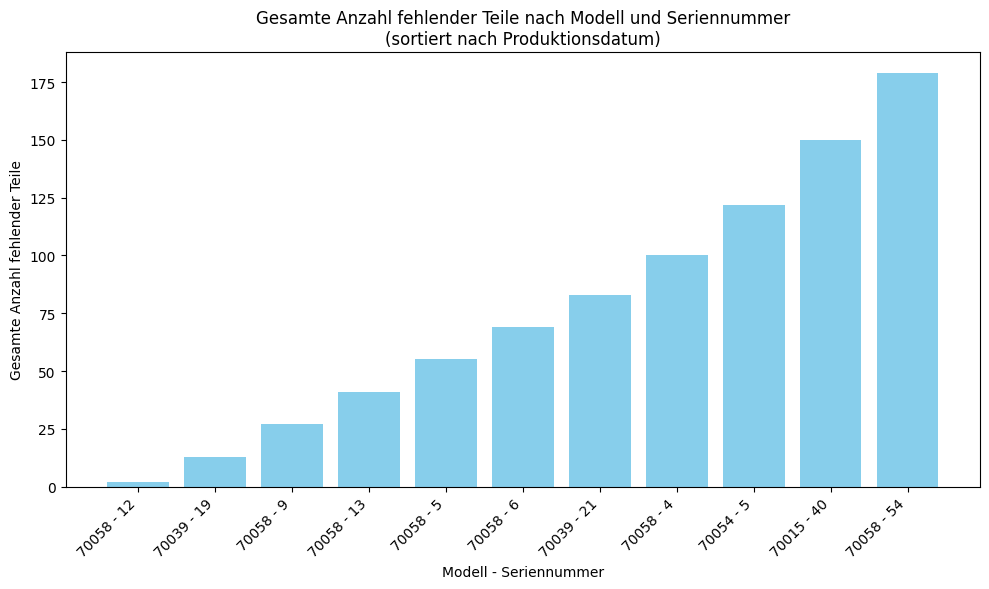

In [2]:
import matplotlib.pyplot as plt

# Wir gehen davon aus, dass order_schedule_df folgende Spalten enthält:
# "Model", "Fahrzeug Nr.", "Teilemangel" und "Termin" (als Produktionsdatum)
# Gruppieren der Daten nach "Model" und "Fahrzeug Nr." und Berechnung von:
# - der Summe der Werte in der Spalte "Teilemangel"
# - dem frühesten Produktionsdatum für jedes Paar
grouped = order_schedule_df.groupby(["Model", "Fahrzeug Nr."]).agg({
    "Teilemangel": "sum",
    "Termin": "min"
}).reset_index()

# Sortieren des Ergebnisses nach der Spalte "Termin"
grouped = grouped.sort_values("Termin")

# Erstellen einer Beschriftungsspalte, indem "Model" und "Fahrzeug Nr." kombiniert werden
grouped["Label"] = grouped["Model"].astype(str) + " - " + grouped["Fahrzeug Nr."].astype(str)

# Erzeugen des Balkendiagramms
plt.figure(figsize=(10, 6))
plt.bar(grouped["Label"], grouped["Teilemangel"], color='skyblue')
plt.title("Gesamte Anzahl fehlender Teile nach Modell und Seriennummer\n(sortiert nach Produktionsdatum)")
plt.xlabel("Modell - Seriennummer")
plt.ylabel("Gesamte Anzahl fehlender Teile")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [3]:
# Przykładowo zakładamy, że order_schedule_df zawiera kolumny:
# ["Termin", "Model", "Sztuka Nr", "Kunde", "Artikel-Nr.", "Brak (szt.)"]

# 1. Grupujemy wiersze po kolumnie "Artikel-Nr." i sumujemy wartość "Brak (szt.)".
zbiorcze_zamowienie = order_schedule_df.groupby("Artikel-Nr.")["Teilemangel"].sum().reset_index()

# 2. Zmieniamy nazwę kolumny z sumą braków, by była bardziej czytelna
zbiorcze_zamowienie.rename(columns={"Teilemangel": "Gesamtzahl der Mängel"}, inplace=True)

# 3. Wyświetlamy zbiorcze zamówienie w konsoli (opcjonalnie)
print(zbiorcze_zamowienie)

# 4. Możemy również zapisać zbiorcze zamówienie do pliku Excel, np.:
zbiorcze_zamowienie.to_excel("Großbestellung.xlsx", index=False)
print("Die Datei 'Großbestellung.xlsx' wurde erstellt.")


   Artikel-Nr.  Gesamtzahl der Mängel
0      0003433                   30.0
1      0003541                   20.0
2      0003942                  210.0
3      0003979                  231.0
4      0038536                  110.0
5      0073668                   66.0
6      0136963                    5.0
7      0140166                   90.0
8      0164222                    4.0
9      0170143                   55.0
10     0179490                   20.0
Die Datei 'Großbestellung.xlsx' wurde erstellt.
